In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import TimeSeriesSplit

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [ ]:
# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from src.io_data_model import (
    load_model,
    load_and_dateindex_data,
    save_model,
)

from src.transformation import (
    clean_delivery_data,
    resample_data,
    smooth_series,
)

from src.anomaly import (
    detect_anomalies,
    calculate_anomaly_percentage,
)

from src.plotting import (
    plot_anomalies,
    plot_anomalies_and_rolling,
    plot_forecast,
    plot_train_splits,
    plot_test_splits,
    plot_eighty_twenty_series,
)

from src.time_series import (
    find_best_arima_order,
    find_best_sarima_model,
    evaluate_models,
    rank_models,
    fit_sarima_model,
    fit_exp_smooth_model,
    fit_prophet_model,
    display_metrics,
)

In [3]:
from soya_delivery_parms import config

CROP = config["CROP"]
DATA_FILE = config["DATA_FILE"]
DATA_FILE_PATH = config["DATA_FILE_PATH"]
MODEL_FILE = config["MODEL_FILE"]
MODEL_PARMS = config["MODEL_PARMS"]
MODEL_PATH = config["MODEL_PATH"]
PERIOD = config["PERIOD"]
ROLLING_AVERAGE_WINDOW = config["ROLLING_AVERAGE_WINDOW"]
SMOOTHED_TARGET_VARIABLE = config["SMOOTHED_TARGET_VARIABLE"]
TARGET_VARIABLE = config["TARGET_VARIABLE"]
TRAIN_SPLIT = config["TRAIN_SPLIT"]

The overall code in this Jupyter Notebook is designed to analyze and forecast crop deliveries using various time series models. The workflow includes data loading, preprocessing, exploratory data analysis, model fitting, evaluation, and forecasting. The models used include SARIMA, Exponential Smoothing, and Prophet. The notebook also includes visualizations to help understand the data and the model outputs.

In [33]:
# loaded_model = load_model(MODEL_PATH, MODEL_FILE)
# print(loaded_model.summary())

In [4]:
indexed_df = load_and_dateindex_data(DATA_FILE_PATH, DATA_FILE)
cleaned_df = clean_delivery_data(indexed_df, TARGET_VARIABLE, CROP)
cleaned_df.head()

,Crop Delivery (Tonnes)
Date,
2018-01-03,258
2018-01-10,982
2018-01-17,1508
2018-01-24,3587
2018-01-31,514


In [5]:
# Get summary statistics
cleaned_df.describe().map(lambda x: f"{x:,.0f}")

,Crop Delivery (Tonnes)
count,364
mean,"34,024"
std,"92,526"
min,0
25%,923
50%,"2,819"
75%,"9,496"
max,"911,419"


<Axes: xlabel='Date', ylabel='Crop Delivery (Tonnes)'>

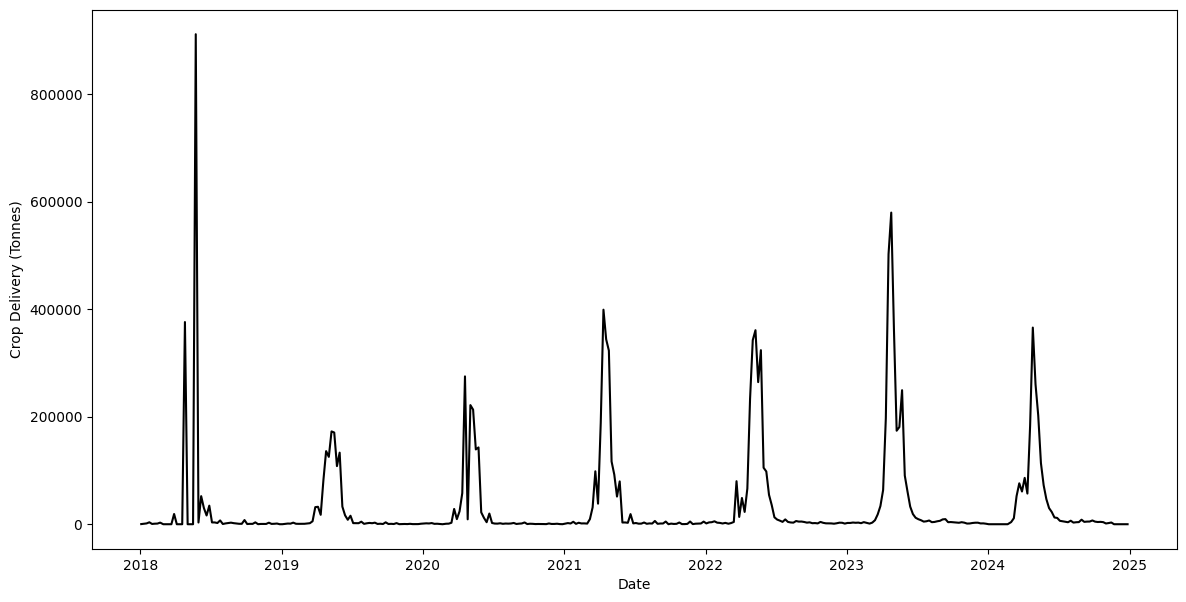

In [6]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=cleaned_df, x=cleaned_df.index, y=TARGET_VARIABLE, color="black")

In [7]:
outlier_df, anomalies = detect_anomalies(cleaned_df, TARGET_VARIABLE, 0.05)
anomaly_df = calculate_anomaly_percentage(outlier_df)
anomaly_df

,Anomaly,Percentage
0,Not Anomaly,94.78022
1,Anomaly,5.21978


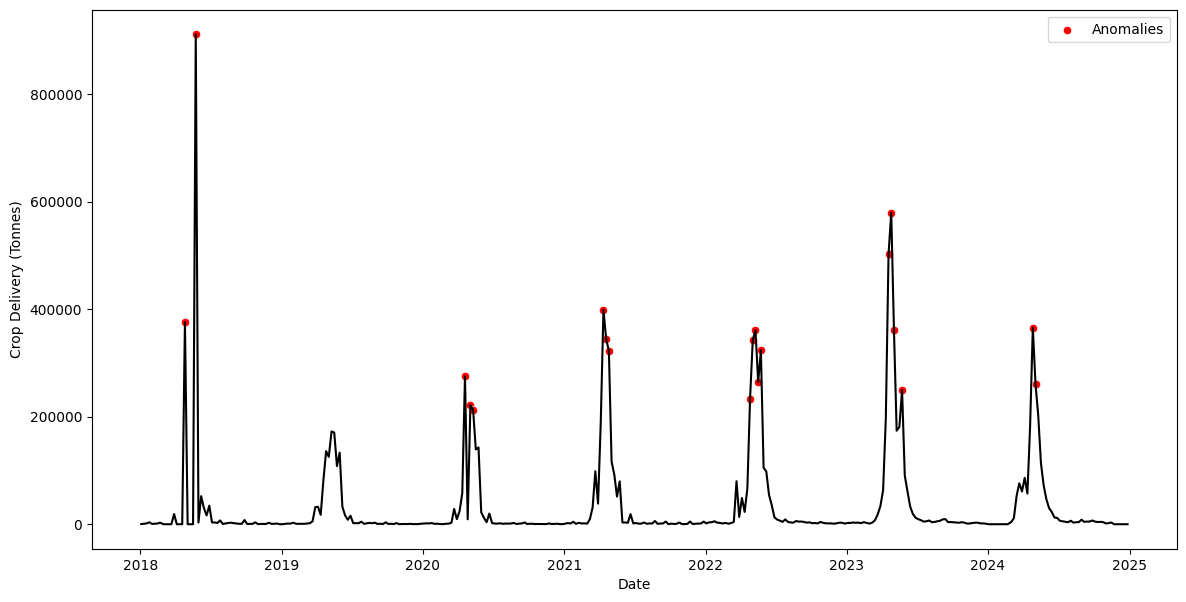

In [8]:
plot_anomalies(outlier_df, anomalies, TARGET_VARIABLE)

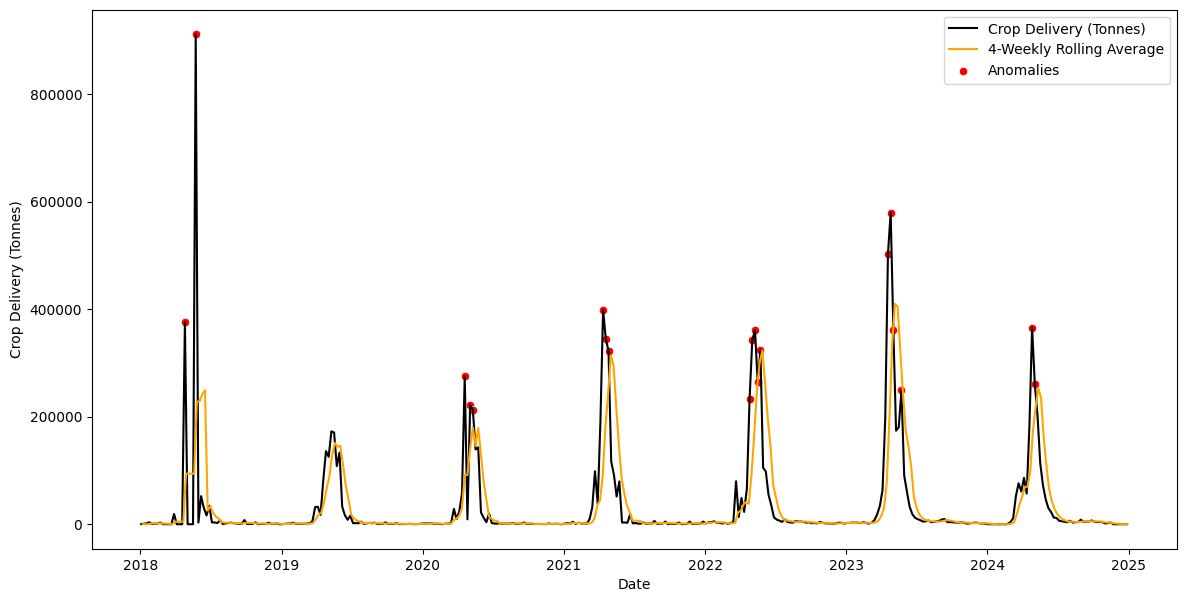

In [9]:
resampled_df = resample_data(outlier_df, TARGET_VARIABLE)
smoothed_series = smooth_series(
    resampled_df, TARGET_VARIABLE, ROLLING_AVERAGE_WINDOW, SMOOTHED_TARGET_VARIABLE
)

# Call the function
plot_anomalies_and_rolling(
    outlier_df, smoothed_series, anomalies, TARGET_VARIABLE, SMOOTHED_TARGET_VARIABLE
)

12:10:35 - cmdstanpy - INFO - Chain [1] start processing
12:10:35 - cmdstanpy - INFO - Chain [1] done processing


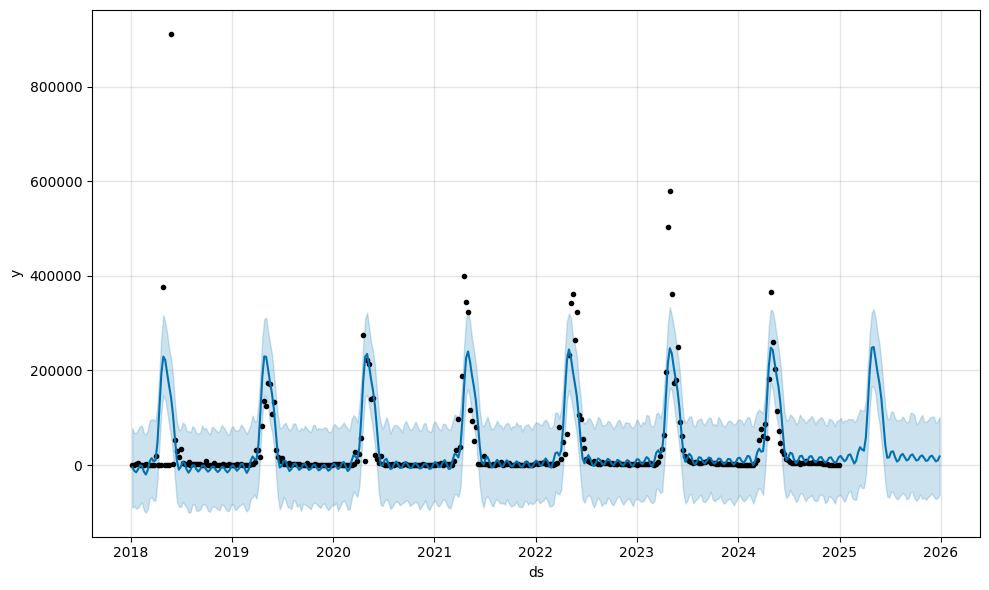

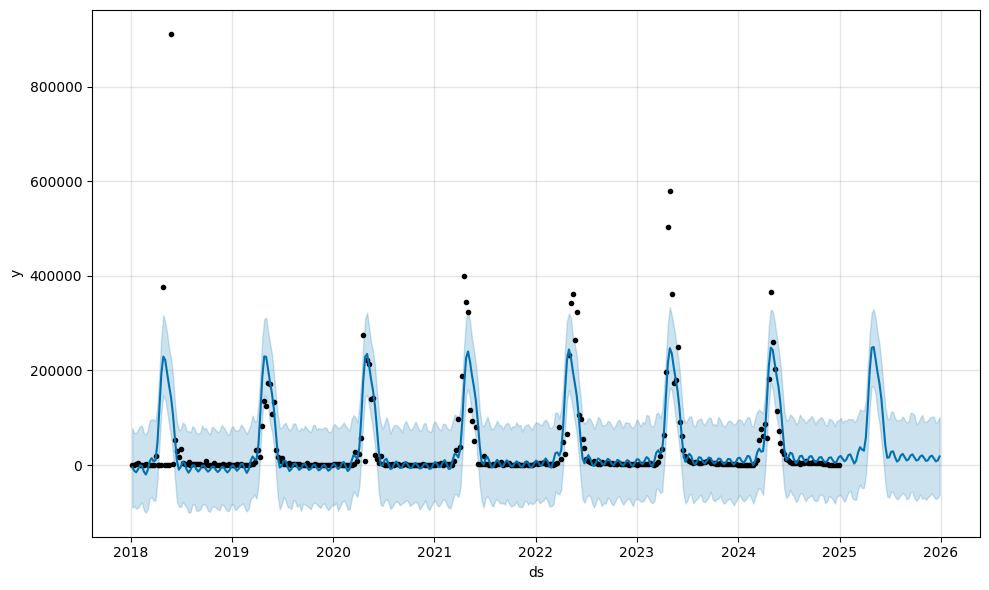

In [10]:
# Create a Prophet model with the default parameters
model = Prophet()
# Fit the model to the data
fb_df = resampled_df.reset_index().rename(columns={"Date": "ds", TARGET_VARIABLE: "y"})
model.fit(fb_df)

# Forecast for the next 52 weeks (for example)
future = model.make_future_dataframe(periods=PERIOD, freq="W")  # weekly forecast
forecast = model.predict(future)
model.plot(forecast)

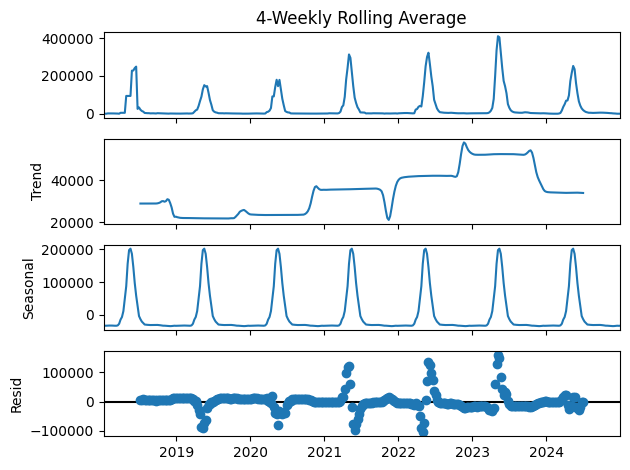

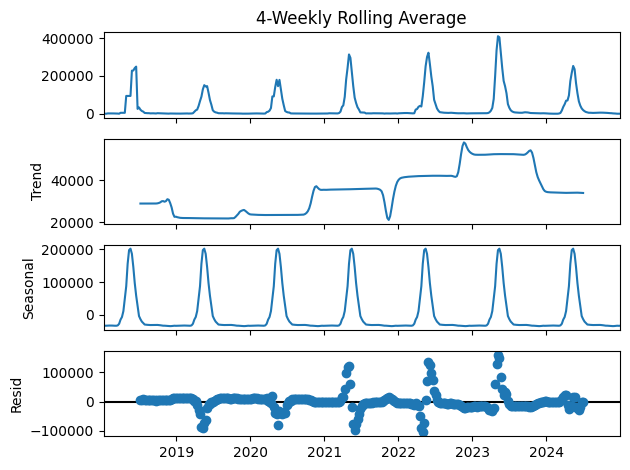

In [11]:
# Decompose the time series using the additive method
decomposition = seasonal_decompose(x=smoothed_series, model="additive", period=PERIOD)
# View the decomposed components
decomposition.plot()

In [12]:
# Perform the ADF test on the time series
result = adfuller(smoothed_series)

# Print the ADF test statistic, the p-value, and the critical values
print("ADF test statistic:", result[0])
print("p-value:", result[1])
print("Critical values:")
for key, value in result[4].items():
    print(key, value)

ADF test statistic: -5.051410937738603
p-value: 1.7540778353823924e-05
Critical values:
1% -3.449336554273722
5% -2.8699055166063085
10% -2.571226758215748


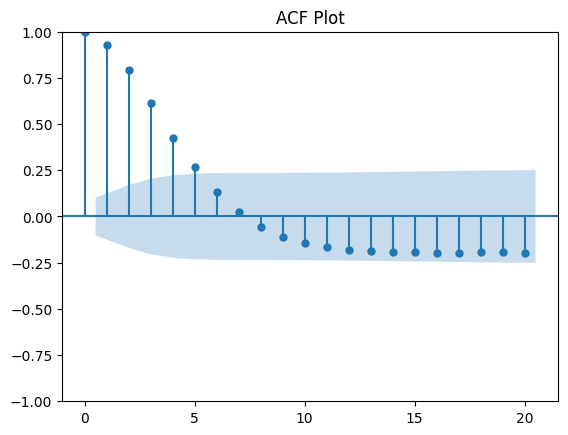

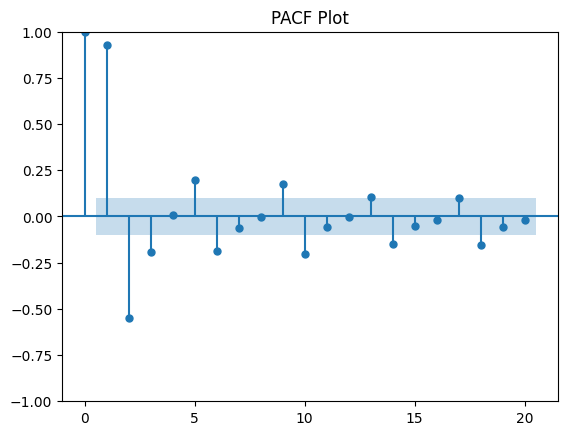

In [13]:
# Generate ACF and PACF plots
plot_acf(smoothed_series, lags=20)
plt.title("ACF Plot")
plt.show()

plot_pacf(smoothed_series, lags=20)
plt.title("PACF Plot")
plt.show()

In [34]:
best_order, best_aic = find_best_arima_order(smoothed_series)
print(f"Best model order: {best_order} with AIC: {best_aic}")

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Best model order: (2, 0, 2) with AIC: 8323.343771998203


In [15]:
# Build an ARIMA(1, 0, 1) model for the time series
model = ARIMA(smoothed_series, order=(2, 0, 2))
# Fit the model to the data
model_fit = model.fit()
# View the summary of the model
print(model_fit.summary())

                                  SARIMAX Results                                   
Dep. Variable:     4-Weekly Rolling Average   No. Observations:                  365
Model:                       ARIMA(2, 0, 2)   Log Likelihood               -4155.672
Date:                      Thu, 12 Dec 2024   AIC                           8323.344
Time:                              12:10:48   BIC                           8346.743
Sample:                          01-07-2018   HQIC                          8332.643
                               - 12-29-2024                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.393e+04    1.6e+04      2.125      0.034    2638.183    6.52e+04
ar.L1          1.3213      0.045     29.669      0.000       1.234       1.409
ar.L

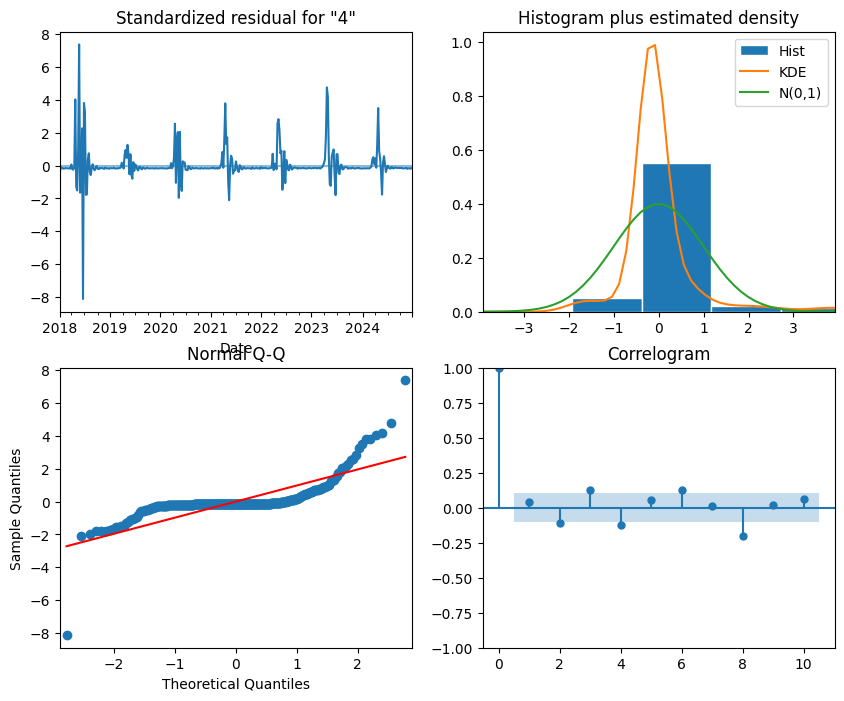

In [16]:
# Plot the diagnostic charts for the model
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

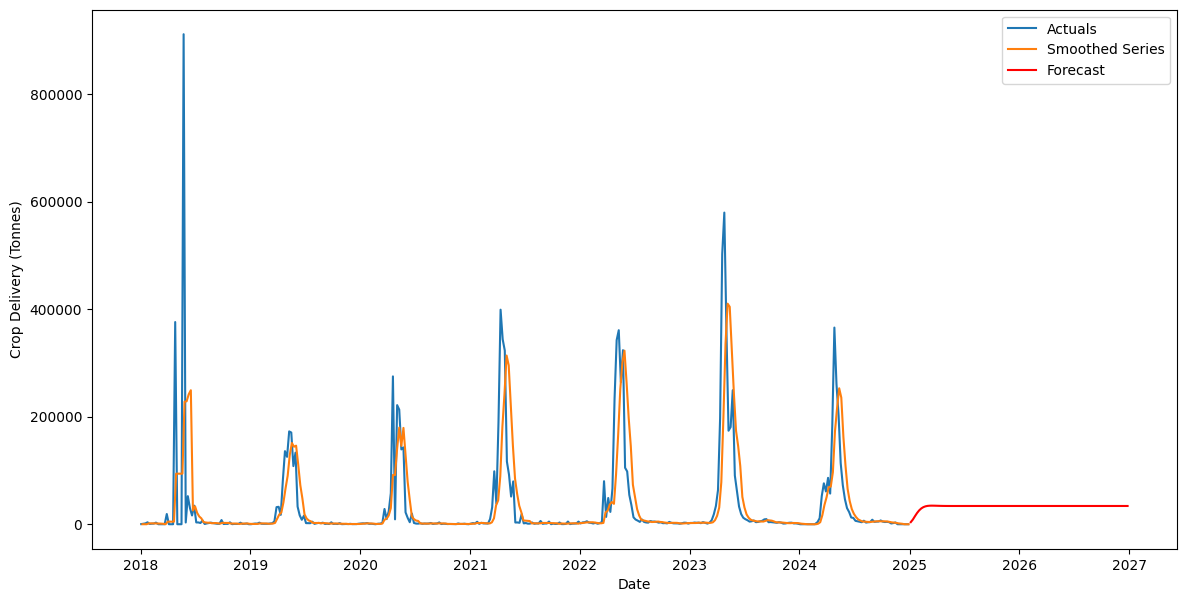

In [17]:
# Forecasting crop deliveries for the next year
num_years = 2
forecast = model_fit.forecast(steps=PERIOD * num_years)

# Call the function
plot_forecast(
    forecast,
    smoothed_series,
    cleaned_df,
    TARGET_VARIABLE,
    SMOOTHED_TARGET_VARIABLE,
    PERIOD,
    num_years,
)

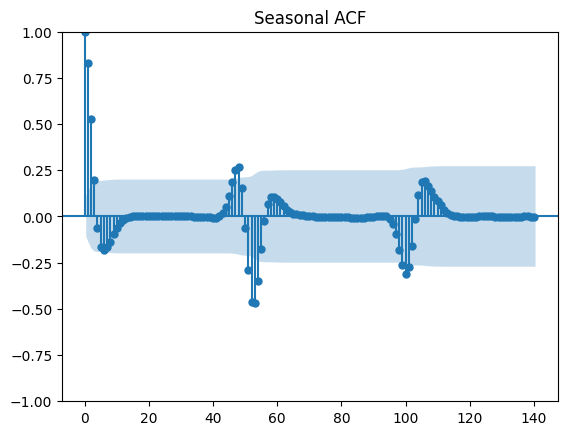

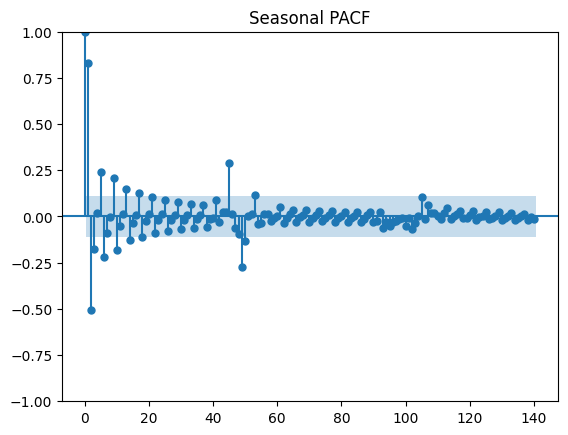

In [18]:
# Seasonal differencing (if necessary)
seasonal_diff = smoothed_series.diff(PERIOD).dropna()

# ACF and PACF for seasonally differenced data
plot_acf(seasonal_diff, lags=140)
plt.title("Seasonal ACF")
plt.show()

plot_pacf(seasonal_diff, lags=140)
plt.title("Seasonal PACF")
plt.show()

In [20]:
# best_order, best_seasonal_order = find_best_sarima_model(
#     resampled_df[TARGET_VARIABLE], PERIOD
# )
# print(f"Best order: {best_order}")
# print(f"Best seasonal order: {best_seasonal_order}")

In [35]:
# Build a seasonal ARIMA model for the time series
model = SARIMAX(
    smoothed_series,
    order=MODEL_PARMS["order"],
    seasonal_order=MODEL_PARMS["seasonal_order"],
)
# Fit the model to the data
model_fit = model.fit()
# View the summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:             4-Weekly Rolling Average   No. Observations:                  365
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 52)   Log Likelihood               -3586.239
Date:                              Thu, 12 Dec 2024   AIC                           7178.479
Time:                                      12:20:11   BIC                           7189.717
Sample:                                  01-07-2018   HQIC                          7182.970
                                       - 12-29-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8661      0.023     37.620      0.000       0.821       0.911
ma.S.L52      -0.62

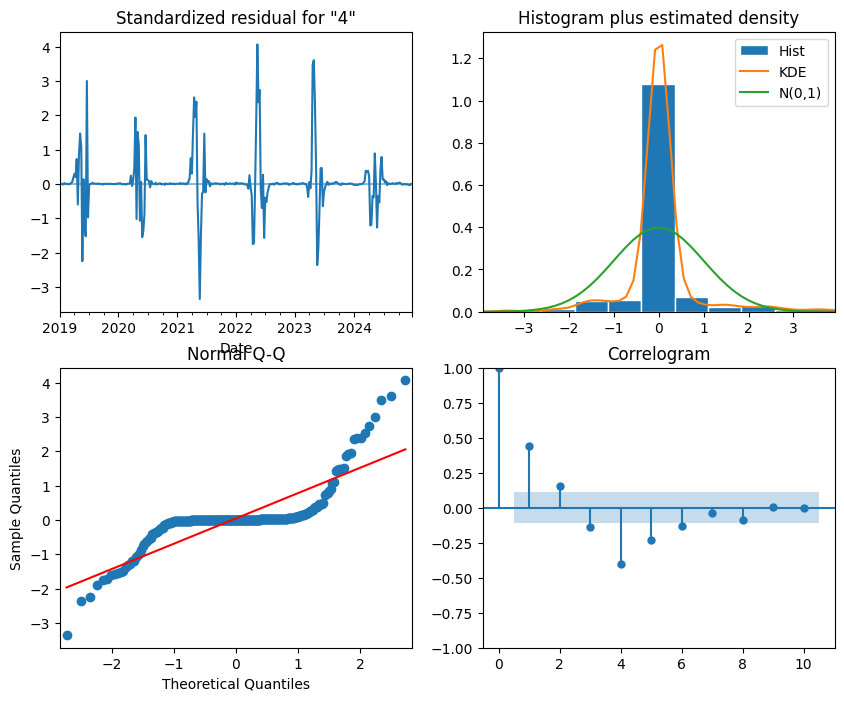

In [36]:
# Plot the diagnostic charts for the model
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

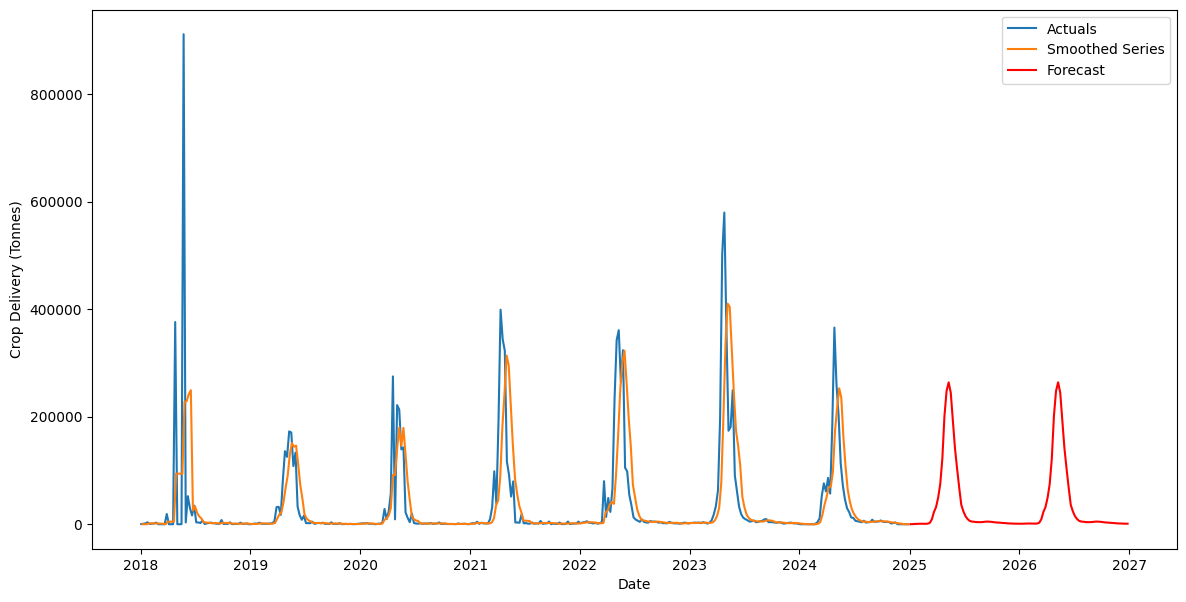

In [37]:
# Forecasting crop deliveries for the next year
num_years = 2
forecast = model_fit.forecast(steps=PERIOD * num_years)

# Call the function
plot_forecast(
    forecast,
    smoothed_series,
    cleaned_df,
    TARGET_VARIABLE,
    SMOOTHED_TARGET_VARIABLE,
    PERIOD,
    num_years,
)

In [19]:
# Apply the Holt-Winters seasonal method with additive trend and seasonality to the time series
model = ExponentialSmoothing(
    smoothed_series, trend="add", seasonal="add", seasonal_periods=PERIOD
)
# Fit the model to the data
model_fit = model.fit()
# View the summary of the model
print(model_fit.summary())

                         ExponentialSmoothing Model Results                         
Dep. Variable:     4-Weekly Rolling Average   No. Observations:                  365
Model:                 ExponentialSmoothing   SSE                   161655585181.238
Optimized:                             True   AIC                           7378.725
Trend:                             Additive   BIC                           7597.120
Seasonal:                          Additive   AICC                          7401.091
Seasonal Periods:                        52   Date:                 Thu, 12 Dec 2024
Box-Cox:                              False   Time:                         12:11:06
Box-Cox Coeff.:                        None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9950000                alpha           

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


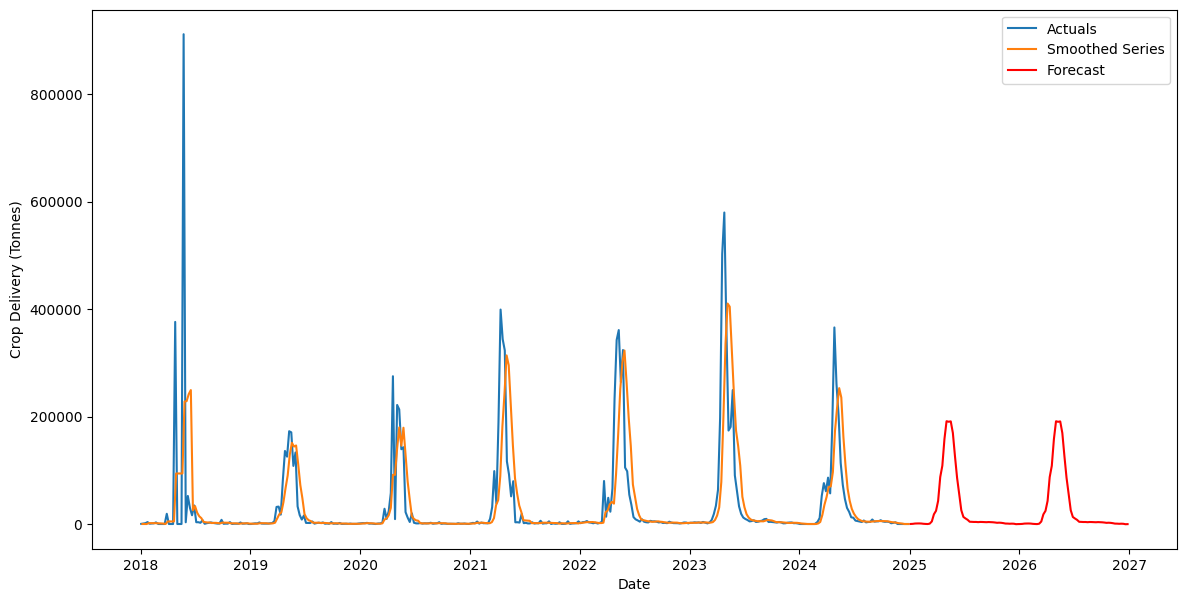

In [20]:
# Forecasting crop deliveries for the next year
num_years = 2
forecast = model_fit.forecast(steps=PERIOD * num_years)
forecast.rename("predicted_mean", inplace=True)

# Call the function
plot_forecast(
    forecast,
    smoothed_series,
    cleaned_df,
    TARGET_VARIABLE,
    SMOOTHED_TARGET_VARIABLE,
    PERIOD,
    num_years,
)

12:11:10 - cmdstanpy - INFO - Chain [1] start processing
12:11:10 - cmdstanpy - INFO - Chain [1] done processing


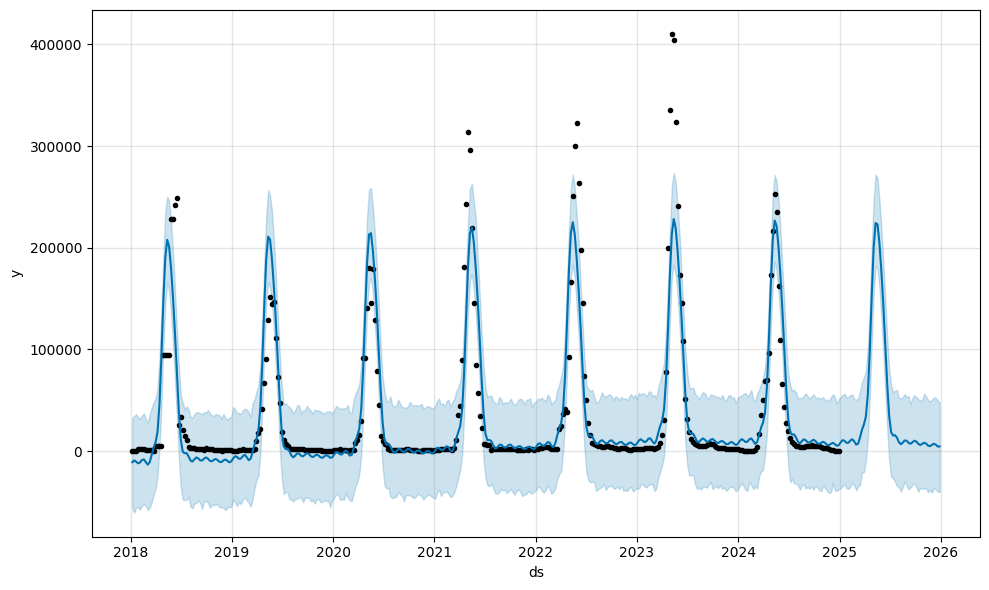

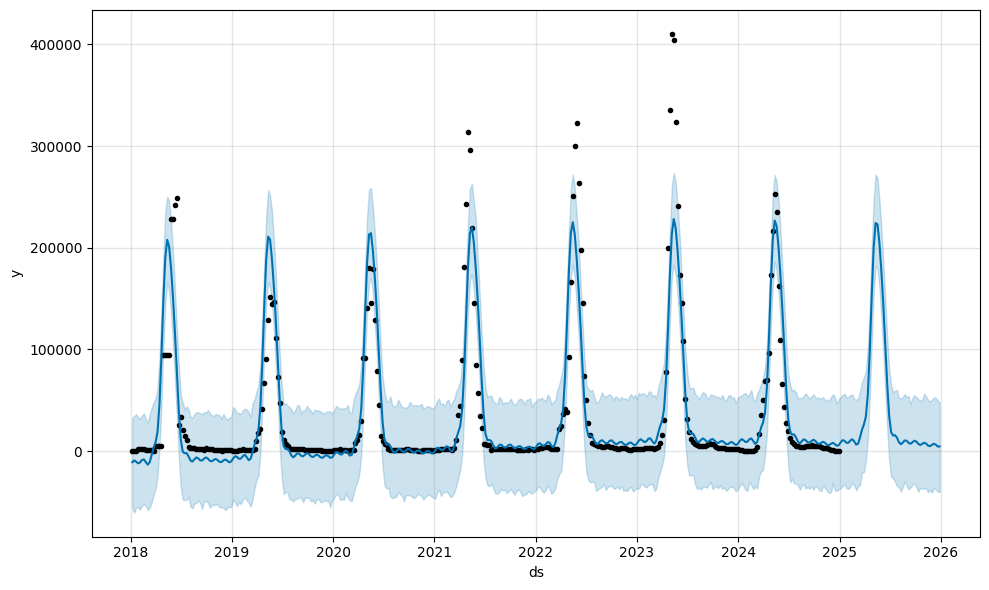

In [21]:
# Create a Prophet model with the default parameters
model = Prophet()
# Fit the model to the data
fb_df = smoothed_series.reset_index().rename(
    columns={"Date": "ds", SMOOTHED_TARGET_VARIABLE: "y"}
)
model.fit(fb_df)

# Forecast for the next 52 weeks (for example)
future = model.make_future_dataframe(periods=PERIOD, freq="W")  # weekly forecast
forecast = model.predict(future)
model.plot(forecast)

Train Split 1: 2018-01-07 to 2019-03-31 (65 samples)
Train Split 2: 2018-01-07 to 2020-05-24 (125 samples)
Train Split 3: 2018-01-07 to 2021-07-18 (185 samples)
Train Split 4: 2018-01-07 to 2022-09-11 (245 samples)
Train Split 5: 2018-01-07 to 2023-11-05 (305 samples)


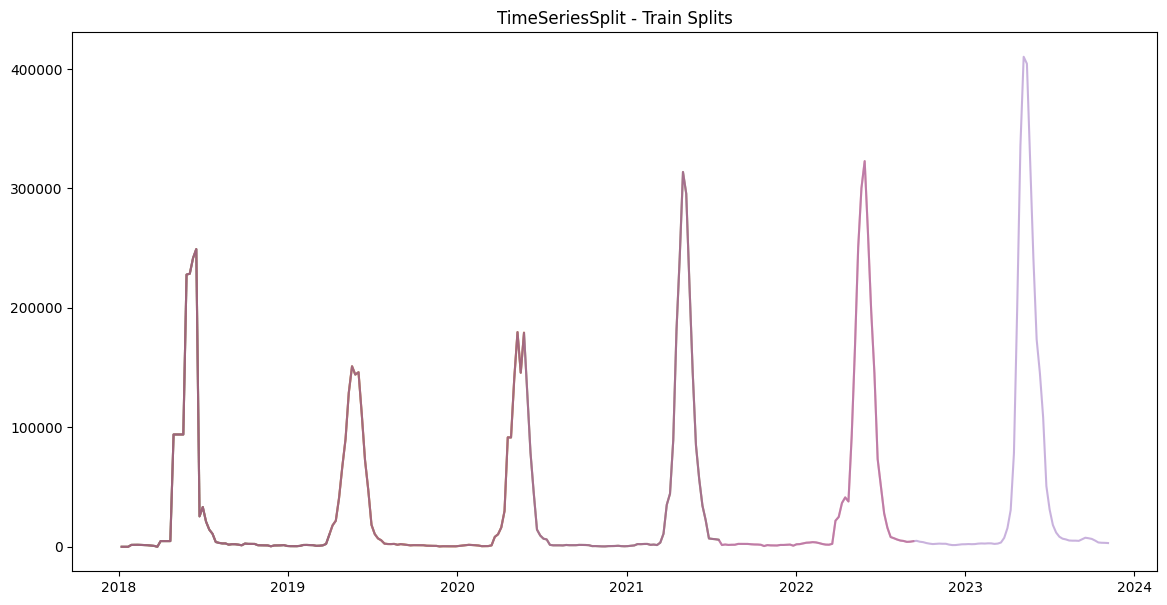

In [22]:
# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit()
plot_train_splits(tscv, smoothed_series)

Test Split 1: 2019-04-07 to 2020-05-24 (60 samples)
Test Split 2: 2020-05-31 to 2021-07-18 (60 samples)
Test Split 3: 2021-07-25 to 2022-09-11 (60 samples)
Test Split 4: 2022-09-18 to 2023-11-05 (60 samples)
Test Split 5: 2023-11-12 to 2024-12-29 (60 samples)


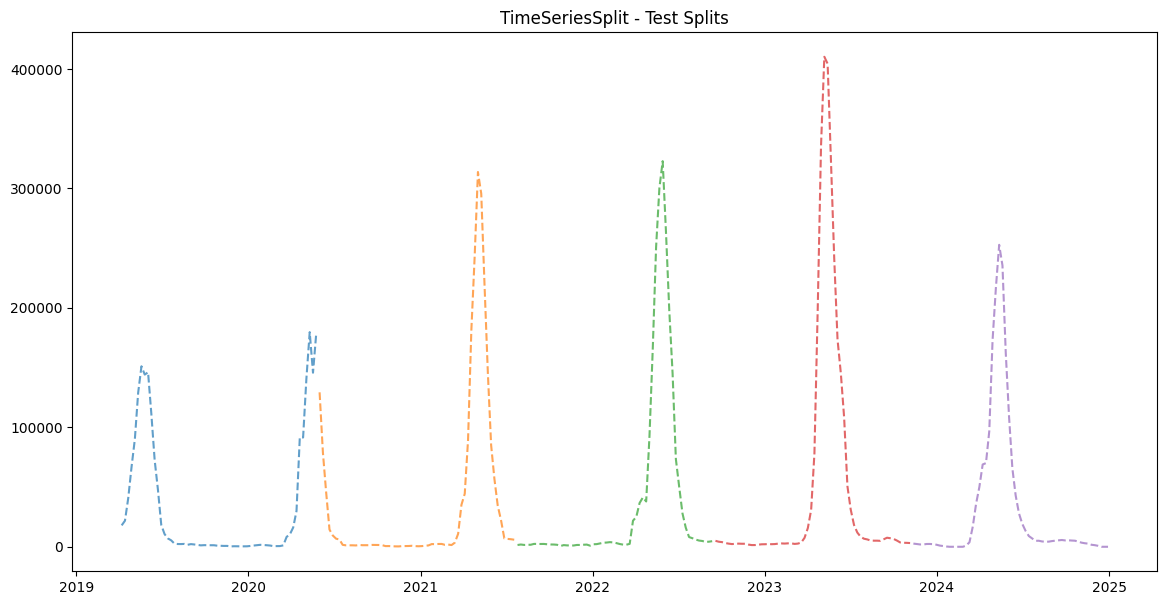

In [23]:
plot_test_splits(tscv, smoothed_series)

In [38]:
tscv = TimeSeriesSplit(n_splits=2)  # Create 4 splits
results = evaluate_models(smoothed_series, tscv, PERIOD, MODEL_PARMS)
results

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
12:21:27 - cmdstanpy - INFO - Chain [1] start processing
12:21:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
12:22:44 - cmdstanpy - INFO - Chain [1] start processing
12:22:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\mario\AppData\Local\Programs\Pyth

,split,sarima_mae,sarima_rmse,exp_mae,exp_rmse,prophet_mae,prophet_rmse
0,1,20739.110083,47054.402707,48455.577480,54216.567236,39371.07300,52892.057944
1,2,13410.465033,38824.873311,16353.318827,42244.436446,26178.16156,43419.747949


In [39]:
ranked_results_df = rank_models(results)

In [24]:
# Assuming 'train' is your training data and 'test' is your test data
eighty_percent = int(TRAIN_SPLIT * len(smoothed_series))
train = smoothed_series[:eighty_percent]  # Example: first 80% for training
test = smoothed_series[eighty_percent:]  # Remaining 20% for testing

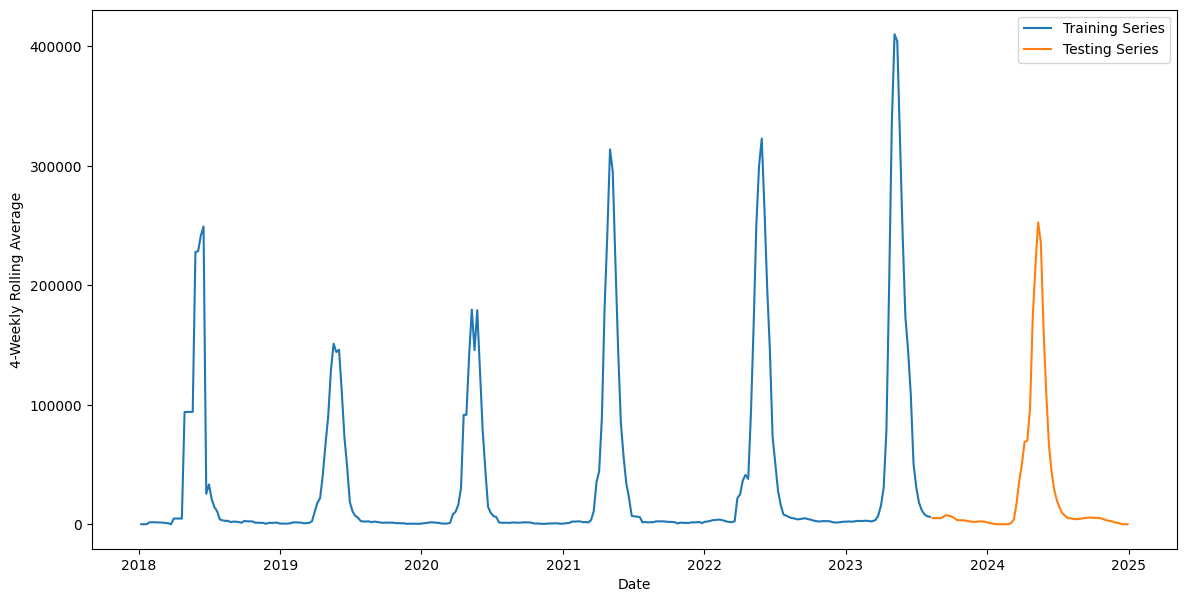

In [25]:
plot_eighty_twenty_series(train, test)

In [40]:
# Call the function
sarima, sarima_forecast, mae_sarima, rmse_sarima = fit_sarima_model(
    train, test, MODEL_PARMS
)

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


SARIMA - MAE: 8538.235505729614, RMSE: 18000.115806501773, MAPE: inf


In [26]:
# Call the function
exp_smooth, exp_smooth_forecast, mae_exp_smooth, rmse_exp_smooth = fit_exp_smooth_model(
    train, test, PERIOD
)

SARIMA - MAE: 5297.114005752074, RMSE: 11398.14119289933, MAPE: inf


c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [45]:
model, prophet_forecast, mae_prophet, rmse_prophet = fit_prophet_model(fb_df, test)

12:31:35 - cmdstanpy - INFO - Chain [1] start processing
12:31:35 - cmdstanpy - INFO - Chain [1] done processing


SARIMA - MAE: 10306.039568198543, RMSE: 16574.015987754494, MAPE: inf


In [51]:
# Create a dictionary with the metrics
metrics = {
    "Model": ["SARIMA", "Exponential Smoothing", "Prophet"],
    "MAE": [mae_sarima, mae_exp_smooth, mae_prophet],
    "RMSE": [rmse_sarima, rmse_exp_smooth, rmse_prophet],
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Call the function
display_metrics(metrics_df)

,Model,MAE,RMSE,MAE Rank,RMSE Rank
1,Exponential Smoothing,5297.114006,11398.141193,1.0,1.0
0,SARIMA,8538.235506,18000.115807,2.0,3.0
2,Prophet,10306.039568,16574.015988,3.0,2.0


<Axes: xlabel='Date', ylabel='4-Weekly Rolling Average'>

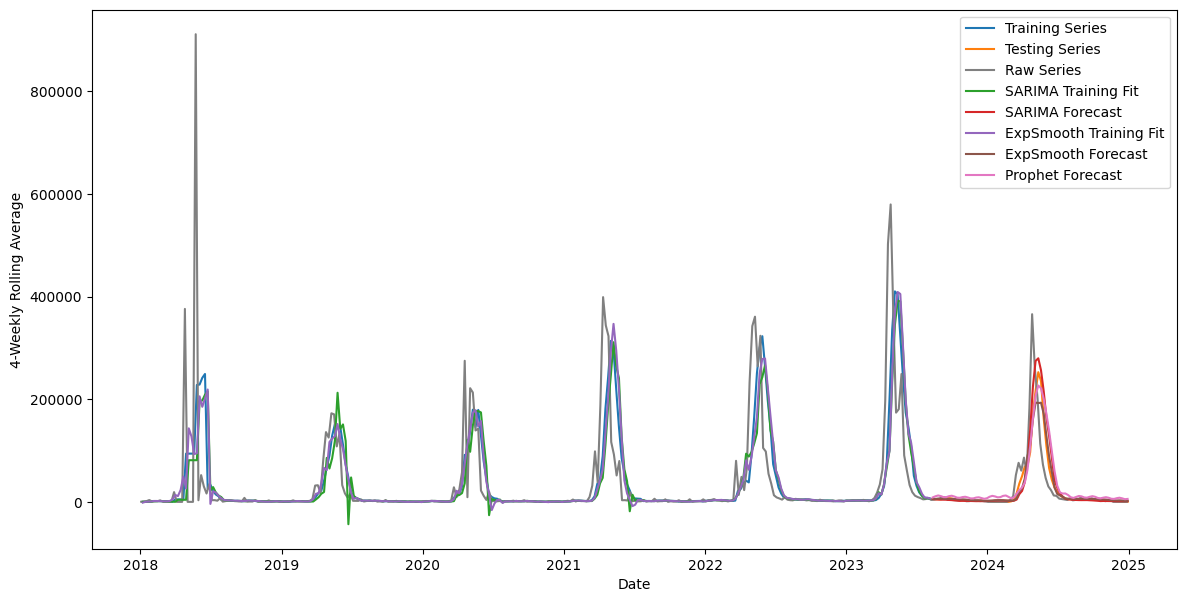

In [57]:
plt.figure(figsize=(14, 7))

# Plot the training series
sns.lineplot(x=train.index, y=train, label="Training Series")

# Plot the testing series
sns.lineplot(x=test.index, y=test, label="Testing Series")

# Plot the original series
sns.lineplot(
    x=cleaned_df.index,
    y=cleaned_df[TARGET_VARIABLE],
    label="Raw Series",
    color="gray",
    dashes=True,
)

# Plot SARIMA model output
sns.lineplot(x=train.index, y=sarima.fittedvalues, label="SARIMA Training Fit")
sns.lineplot(x=test.index, y=sarima_forecast, label="SARIMA Forecast")

# Plot Exp model output
sns.lineplot(x=train.index, y=exp_smooth.fittedvalues, label="ExpSmooth Training Fit")
sns.lineplot(x=test.index, y=exp_smooth_forecast, label="ExpSmooth Forecast")

# Plot Prophet model output
sns.lineplot(
    x=prophet_forecast.index,
    y=prophet_forecast.to_frame()["yhat"],
    label="Prophet Forecast",
)

<Axes: xlabel='Date', ylabel='4-Weekly Rolling Average'>

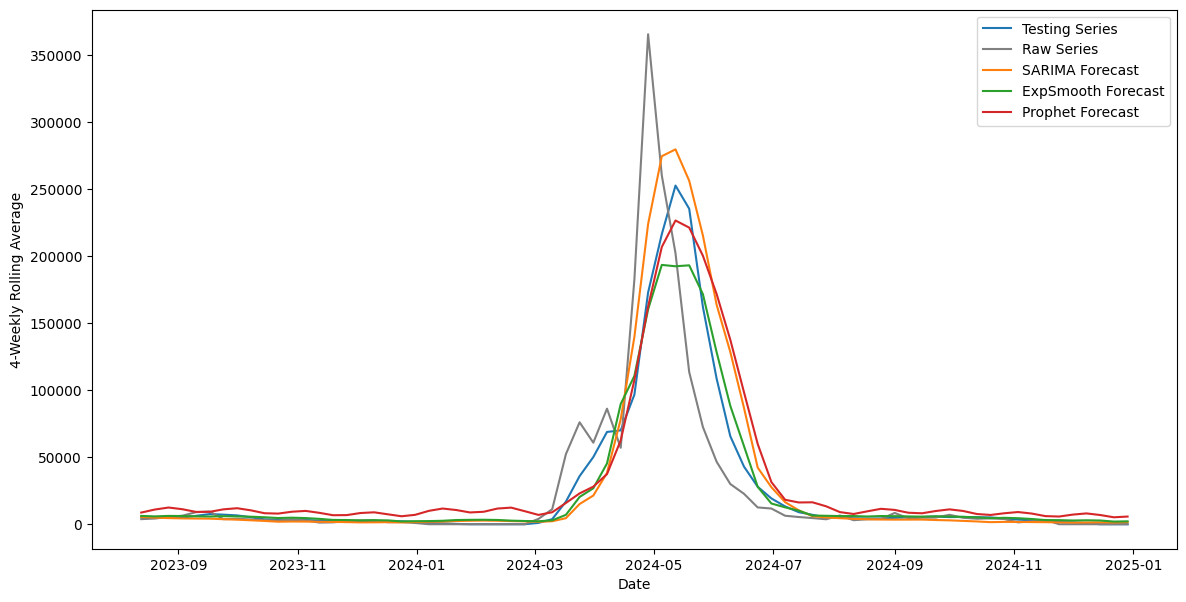

In [58]:
plt.figure(figsize=(14, 7))

# Plot the testing series
sns.lineplot(x=test.index, y=test, label="Testing Series")

# Plot the original series
sns.lineplot(
    x=resampled_df.loc[test.index].index,
    y=resampled_df.loc[test.index, TARGET_VARIABLE],
    label="Raw Series",
    color="gray",
    dashes=True,
)

# Plot SARIMA model output
sns.lineplot(x=test.index, y=sarima_forecast.loc[test.index], label="SARIMA Forecast")

# Plot Exp model output
sns.lineplot(
    x=test.index, y=exp_smooth_forecast.loc[test.index], label="ExpSmooth Forecast"
)

# Plot Prophet model output
sns.lineplot(x=test.index, y=prophet_forecast.loc[test.index], label="Prophet Forecast")

In [ ]:
save_model(model, MODEL_PATH, MODEL_FILE)